In [ ]:

# 1. Setup: Install and import libraries
# This cell installs LIME (for model explanations)
# and imports all libraries used throughout the notebook.
# The purpose of these imports is to load tools for:
# - data handling (pandas, numpy)
# - visualisation (matplotlib, seaborn)
# - machine learning (Random Forest, Gaussian Mixture, metrics)
# - local interpretability (LIME)

!pip install -q lime

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, classification_report

from lime.lime_tabular import LimeTabularExplainer

sns.set(style="whitegrid")
print("Libraries imported.")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Libraries imported.


In [1]:

# 2. Load dataset from Google Drive


drive.mount("/content/drive")

DATA_PATH = "/content/drive/MyDrive/Dissertation/Loan_with_gender_race.csv"
TARGET_COL = "LoanApproved"

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()


NameError: name 'drive' is not defined

In [ ]:

# 3. Define features (numeric + sensitive)


# Main numeric features for modelling (non-sensitive)
numeric_features = [
    "Age",
    "AnnualIncome",
    "CreditScore",
    "LoanAmount",
    "LoanDuration",
    "DebtToIncomeRatio",
    "EmploymentLength"
]

numeric_features = [f for f in numeric_features if f in df.columns]

# Sensitive attributes for bias analysis
sensitive_features_all = ["Gender", "Race", "MaritalStatus"]
sensitive_features = [c for c in sensitive_features_all if c in df.columns]

print("Numeric features used:\n", numeric_features)
print("\nSensitive features detected:\n", sensitive_features)


Numeric features used:
 ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'DebtToIncomeRatio']

Sensitive features detected:
 ['Gender', 'Race', 'MaritalStatus']


In [ ]:

# 4. Basic EDA: info, summary, missing values


cols_for_eda = numeric_features + [TARGET_COL] + sensitive_features

print("\n=== Basic info ===")
print(df[cols_for_eda].info())

print("\n=== Summary statistics (numeric + target) ===")
print(df[numeric_features + [TARGET_COL]].describe())

print("\n=== Missing values ===")
print(df[cols_for_eda].isnull().sum())



=== Basic info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                20000 non-null  int64  
 1   AnnualIncome       20000 non-null  int64  
 2   CreditScore        20000 non-null  int64  
 3   LoanAmount         20000 non-null  int64  
 4   LoanDuration       20000 non-null  int64  
 5   DebtToIncomeRatio  20000 non-null  float64
 6   LoanApproved       20000 non-null  int64  
 7   Gender             20000 non-null  object 
 8   Race               20000 non-null  object 
 9   MaritalStatus      20000 non-null  object 
dtypes: float64(1), int64(6), object(3)
memory usage: 1.5+ MB
None

=== Summary statistics (numeric + target) ===
                Age   AnnualIncome   CreditScore     LoanAmount  LoanDuration  \
count  20000.000000   20000.000000  20000.000000   20000.000000  20000.000000   
mean      39.752600

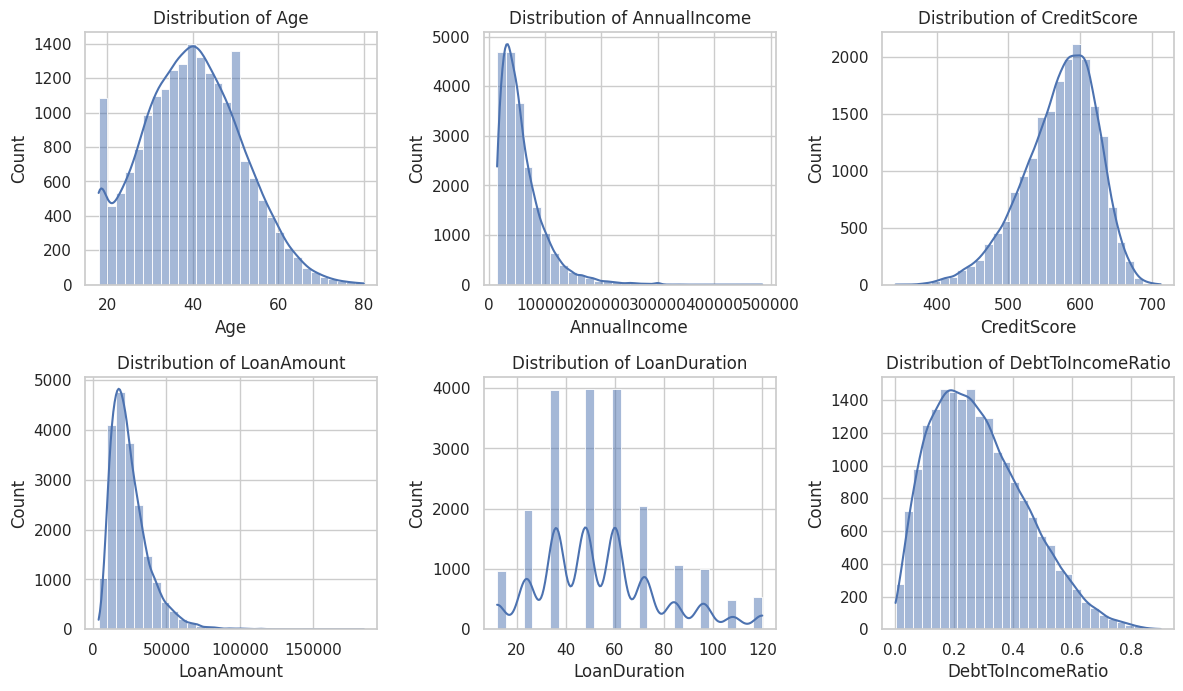

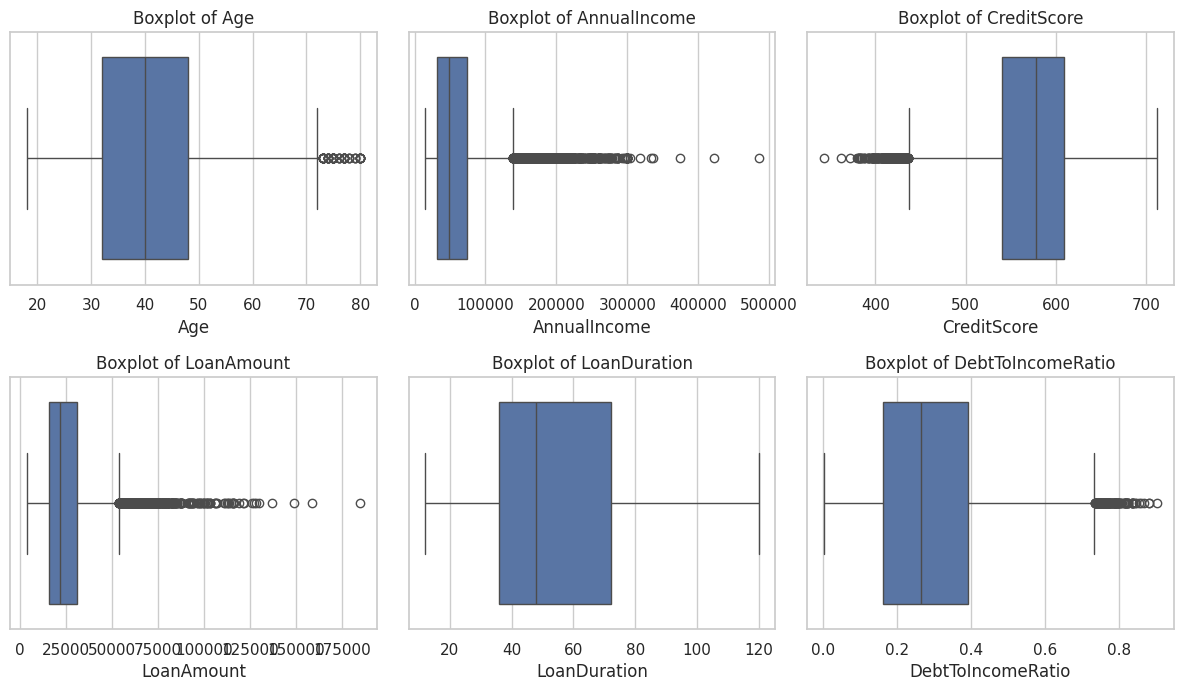

In [ ]:

# 5. EDA: Histograms and boxplots for numeric features


plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


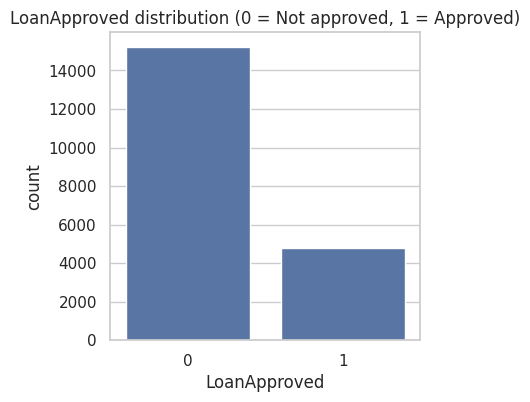

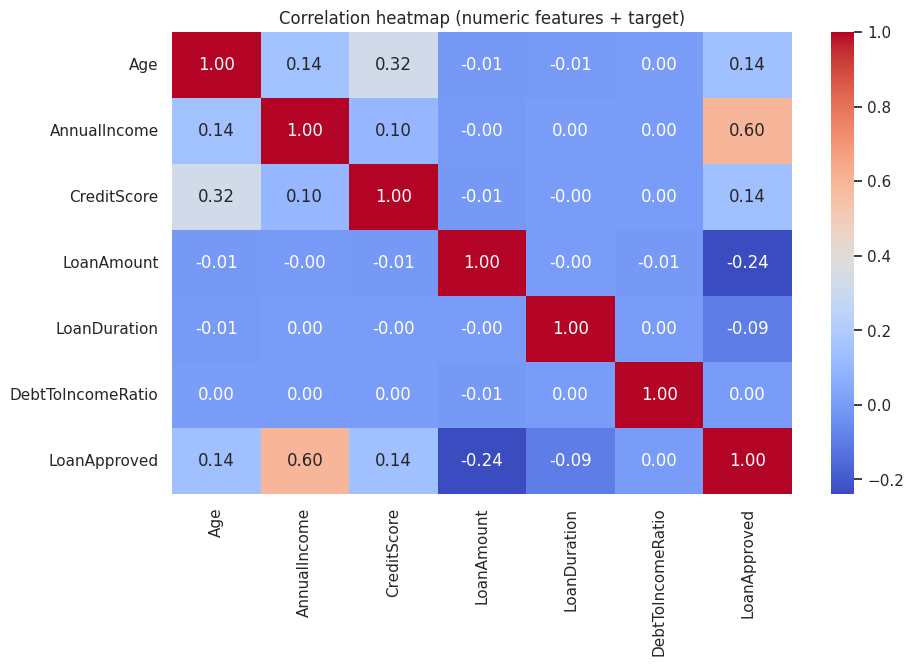

In [ ]:

# 6. EDA: Target distribution and correlation heatmap


plt.figure(figsize=(4, 4))
sns.countplot(x=df[TARGET_COL])
plt.title("LoanApproved distribution (0 = Not approved, 1 = Approved)")
plt.show()

plt.figure(figsize=(10, 6))
corr = df[numeric_features + [TARGET_COL]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation heatmap (numeric features + target)")
plt.show()


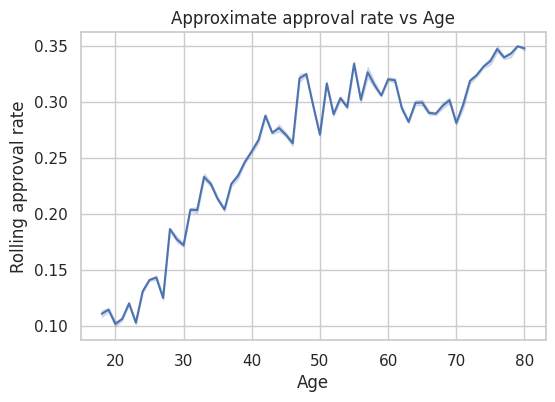

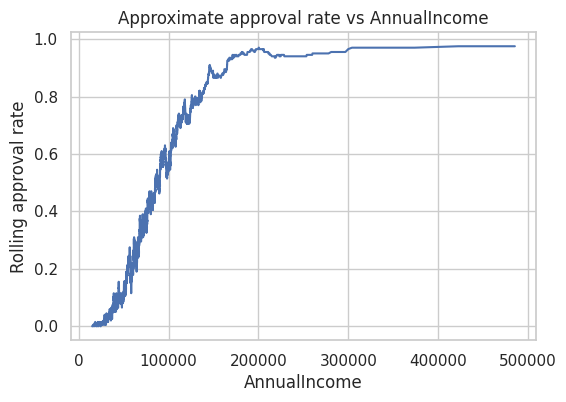

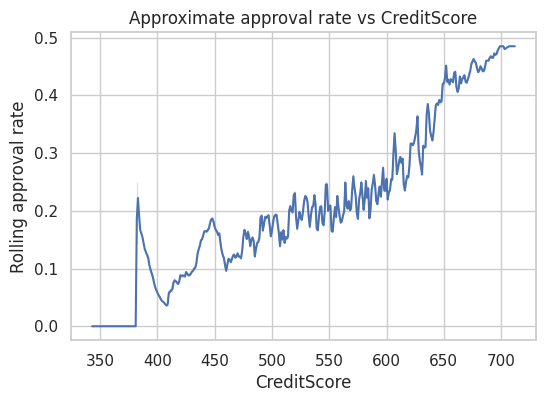

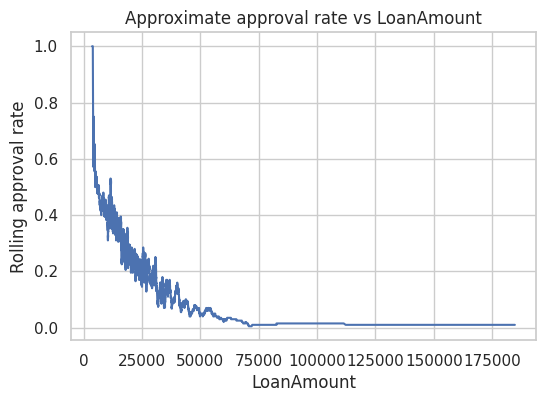

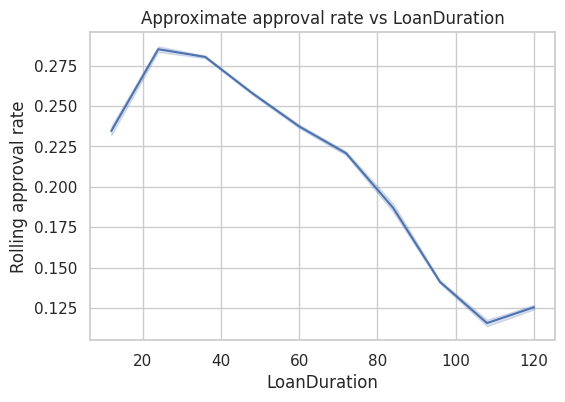

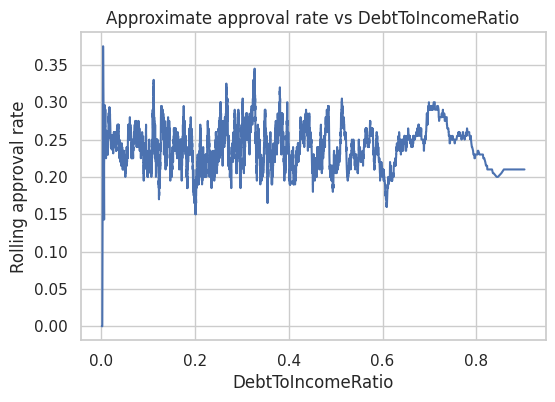

In [ ]:

# 7. EDA: Approval trends vs each numeric feature

for col in numeric_features:
    temp = df[[col, TARGET_COL]].dropna().sort_values(col)
    rolling_mean = temp[TARGET_COL].rolling(window=200, min_periods=1).mean()

    plt.figure(figsize=(6, 4))
    sns.lineplot(x=temp[col], y=rolling_mean)
    plt.title(f"Approximate approval rate vs {col}")
    plt.xlabel(col)
    plt.ylabel("Rolling approval rate")
    plt.show()


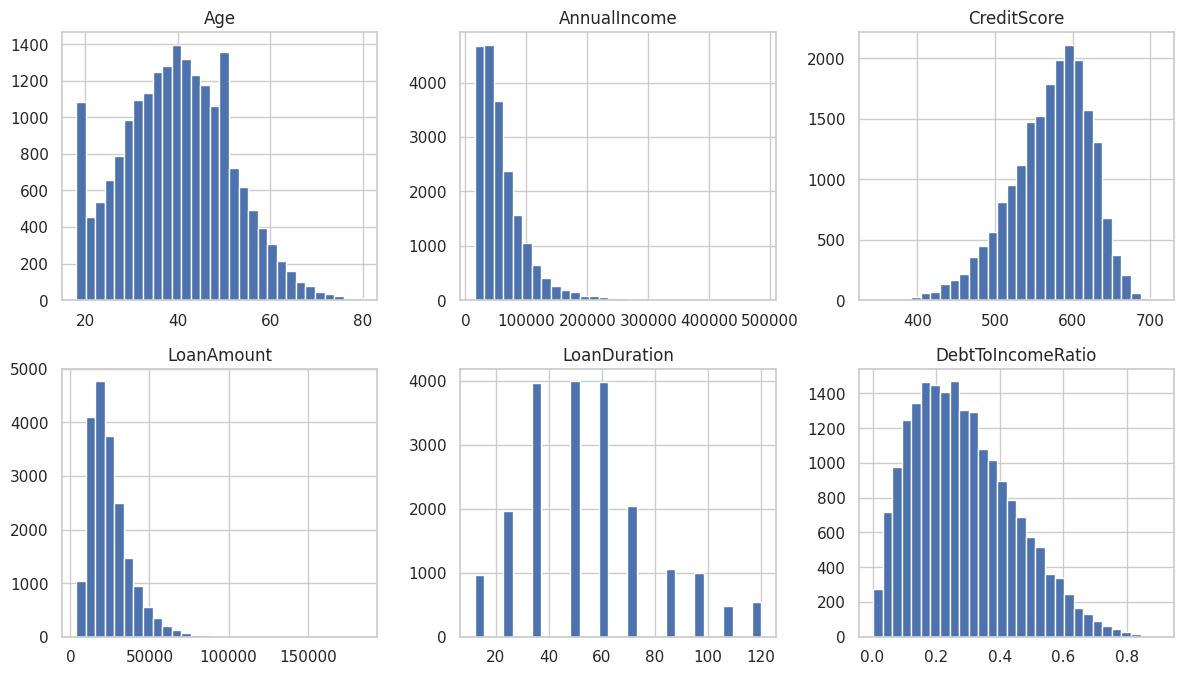

Columns that appear multimodal (more than one peak):
['Age', 'AnnualIncome', 'LoanAmount', 'LoanDuration', 'DebtToIncomeRatio']


In [ ]:

# 8. EDA: Multimodality check (approximate)


from scipy.signal import find_peaks

multimodal_cols = []

plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_features, 1):
    data = df[col].dropna()
    counts, _ = np.histogram(data, bins=30)
    peaks, _ = find_peaks(counts)

    if len(peaks) > 1:
        multimodal_cols.append(col)

    plt.subplot(3, 3, i)
    plt.hist(data, bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

print("Columns that appear multimodal (more than one peak):")
print(multimodal_cols)



=== Spread graphs for Gender, Race, MaritalStatus ===


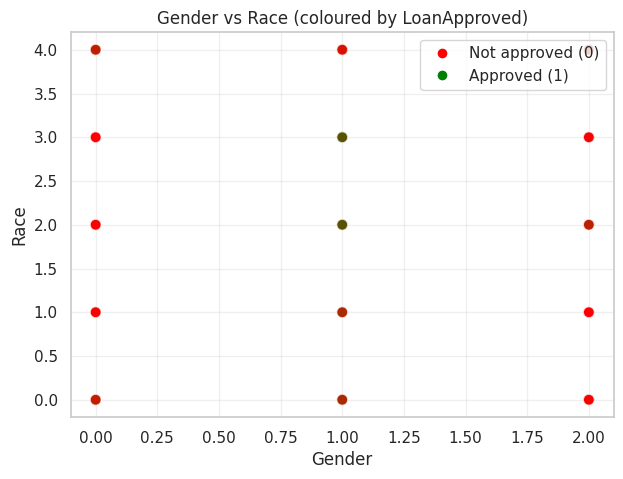

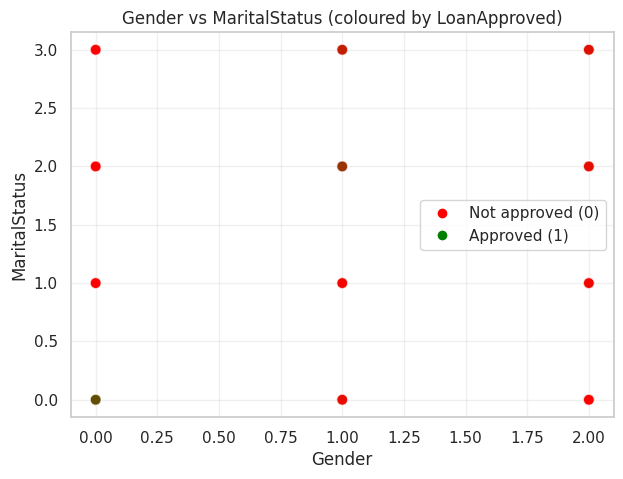

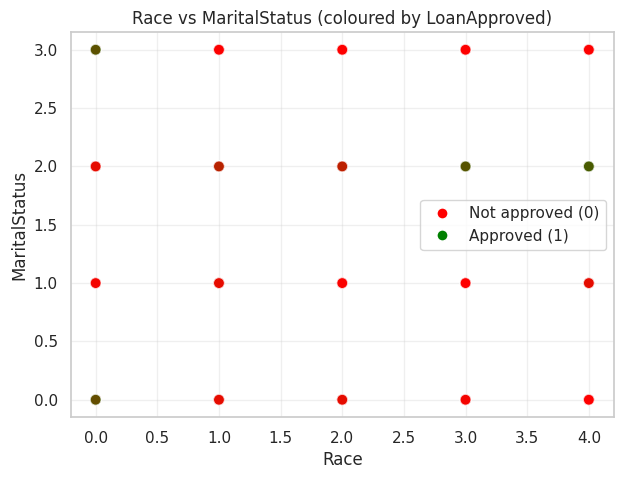

In [ ]:

# 9. Spread graphs for Gender, Race, MaritalStatus


print("\n=== Spread graphs for Gender, Race, MaritalStatus ===")

if len(sensitive_features) >= 2:
    from itertools import combinations

    df_vis = df.copy()
    for col in sensitive_features:
        df_vis[col] = df_vis[col].astype("category").cat.codes

    color_map = {0: "red", 1: "green"}

    pairs = list(combinations(sensitive_features, 2))

    for x_col, y_col in pairs:
        plt.figure(figsize=(7, 5))
        sns.scatterplot(
            data=df_vis,
            x=x_col,
            y=y_col,
            hue=df_vis[TARGET_COL],
            palette=color_map,
            alpha=0.6,
            s=60
        )
        plt.title(f"{x_col} vs {y_col} (coloured by LoanApproved)")
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        red = plt.Line2D([0], [0], marker='o', color='w',
                         label='Not approved (0)', markerfacecolor='red', markersize=8)
        green = plt.Line2D([0], [0], marker='o', color='w',
                           label='Approved (1)', markerfacecolor='green', markersize=8)
        plt.legend(handles=[red, green])
        plt.grid(alpha=0.3)
        plt.show()
else:
    print("Not enough sensitive columns for spread graphs.")




In [ ]:

# 10. Encode sensitive features and build feature sets


df_enc = df.copy()
category_maps = {}

for col in sensitive_features:
    df_enc[col] = df_enc[col].astype("category")
    category_maps[col] = list(df_enc[col].cat.categories)
    df_enc[col] = df_enc[col].cat.codes

X_no_bias = df_enc[numeric_features]
X_with_bias = df_enc[numeric_features + sensitive_features]
y = df_enc[TARGET_COL]

print("Shape without sensitive features:", X_no_bias.shape)
print("Shape with sensitive features:   ", X_with_bias.shape)


Shape without sensitive features: (20000, 6)
Shape with sensitive features:    (20000, 9)


In [ ]:

# 11. Train/test split (same indices for both feature sets)


indices = np.arange(len(df_enc))

train_idx, test_idx = train_test_split(
    indices,
    test_size=0.20,
    stratify=y,
    random_state=42
)

X_train_nb = X_no_bias.iloc[train_idx]
X_test_nb  = X_no_bias.iloc[test_idx]

X_train_wb = X_with_bias.iloc[train_idx]
X_test_wb  = X_with_bias.iloc[test_idx]

y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

print("Train shapes (no bias / with bias):", X_train_nb.shape, X_train_wb.shape)
print("Test shapes (no bias / with bias): ", X_test_nb.shape, X_test_wb.shape)


Train shapes (no bias / with bias): (16000, 6) (16000, 9)
Test shapes (no bias / with bias):  (4000, 6) (4000, 9)


In [ ]:

# 12. Random Forest models (without bias and with bias)


rf_no_bias = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
rf_no_bias.fit(X_train_nb, y_train)

rf_with_bias = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=42
)
rf_with_bias.fit(X_train_wb, y_train)

pred_rf_nb = rf_no_bias.predict(X_test_nb)
pred_rf_wb = rf_with_bias.predict(X_test_wb)

print("\n=== Random Forest (without sensitive features) ===")
print("Accuracy:", round(accuracy_score(y_test, pred_rf_nb), 3))
print(classification_report(y_test, pred_rf_nb))

print("\n=== Random Forest (with sensitive features) ===")
print("Accuracy:", round(accuracy_score(y_test, pred_rf_wb), 3))
print(classification_report(y_test, pred_rf_wb))



=== Random Forest (without sensitive features) ===
Accuracy: 0.881
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3044
           1       0.79      0.68      0.73       956

    accuracy                           0.88      4000
   macro avg       0.85      0.81      0.83      4000
weighted avg       0.88      0.88      0.88      4000


=== Random Forest (with sensitive features) ===
Accuracy: 0.879
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      3044
           1       0.79      0.67      0.73       956

    accuracy                           0.88      4000
   macro avg       0.85      0.81      0.82      4000
weighted avg       0.88      0.88      0.88      4000



In [ ]:

# 13. Bayesian classifier (GaussianMixtureNB) – class definition


class GaussianMixtureNB:
    """
    Simple Naive Bayes-style classifier where each (class, feature)
    distribution is modelled using a 1D Gaussian Mixture.
    """
    def __init__(self, n_components=2, random_state=42):
        self.n_components = n_components
        self.random_state = random_state

    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        self.features_ = X.columns
        self.models_ = {}

        for cls in self.classes_:
            X_cls = X[y == cls]
            self.models_[cls] = []
            for col in self.features_:
                gmm = GaussianMixture(
                    n_components=self.n_components,
                    reg_covar=1e-3,
                    random_state=self.random_state
                )
                gmm.fit(X_cls[[col]])
                self.models_[cls].append(gmm)
        return self

    def _log_likelihood_class(self, x, cls):
        ll = 0.0
        for i, gmm in enumerate(self.models_[cls]):
            ll += gmm.score_samples([[x[i]]])[0]
        return ll

    def predict(self, X):
        preds = []
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.features_)
        for _, row in X.iterrows():
            x = row.values
            log_lik = {cls: self._log_likelihood_class(x, cls) for cls in self.classes_}
            best_cls = max(log_lik, key=log_lik.get)
            preds.append(best_cls)
        return np.array(preds)

    def predict_proba(self, X):
        all_probs = []
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X, columns=self.features_)
        for _, row in X.iterrows():
            x = row.values
            log_lik = {cls: self._log_likelihood_class(x, cls) for cls in self.classes_}
            m = max(log_lik.values())
            exp_lik = {cls: np.exp(v - m) for cls, v in log_lik.items()}
            total = sum(exp_lik.values())
            probs = [exp_lik[cls] / total for cls in self.classes_]
            all_probs.append(probs)
        return np.array(all_probs)


In [ ]:

# 14. Train Bayesian classifier (with and without bias)


bayes_no_bias = GaussianMixtureNB()
bayes_no_bias.fit(X_train_nb, y_train)

bayes_with_bias = GaussianMixtureNB()
bayes_with_bias.fit(X_train_wb, y_train)

pred_bayes_nb = bayes_no_bias.predict(X_test_nb)
pred_bayes_wb = bayes_with_bias.predict(X_test_wb)

print("\n=== Bayesian classifier (without sensitive features) ===")
print("Accuracy:", round(accuracy_score(y_test, pred_bayes_nb), 3))
print(classification_report(y_test, pred_bayes_nb))

print("\n=== Bayesian classifier (with sensitive features) ===")
print("Accuracy:", round(accuracy_score(y_test, pred_bayes_wb), 3))
print(classification_report(y_test, pred_bayes_wb))



=== Bayesian classifier (without sensitive features) ===
Accuracy: 0.834
              precision    recall  f1-score   support

           0       0.95      0.83      0.88      3044
           1       0.61      0.85      0.71       956

    accuracy                           0.83      4000
   macro avg       0.78      0.84      0.80      4000
weighted avg       0.87      0.83      0.84      4000


=== Bayesian classifier (with sensitive features) ===
Accuracy: 0.829
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      3044
           1       0.60      0.84      0.70       956

    accuracy                           0.83      4000
   macro avg       0.77      0.83      0.79      4000
weighted avg       0.86      0.83      0.84      4000



In [ ]:

# 15. Helper: map probability to decision label

def decision_from_proba(p, threshold=0.40):
    """Convert approval probability into a decision label."""
    return "LOAN APPROVED" if p >= threshold else "LOAN NOT APPROVED"


In [ ]:

# 16. Single user input (used for all four models)


def get_user_input():
    """
    Collect numeric features from the user once,
    and then collect sensitive attributes for bias analysis.
    """
    print("\n--- Enter applicant details (numeric features) ---")
    numeric_vals = {}

    for f in numeric_features:
        if f == "DebtToIncomeRatio":
            median_val = df[f].median()
            numeric_vals[f] = median_val
            print(f"{f}: auto-filled with dataset median ({median_val:.2f})")
        else:
            numeric_vals[f] = float(input(f"{f}: "))

    sensitive_vals = {}
    if len(sensitive_features) > 0:
        print("\n--- Enter sensitive attributes (for bias analysis) ---")
        for col in sensitive_features:
            options = category_maps[col]
            print(f"\n{col} options:", options)
            raw = input(f"{col} (type exactly as shown): ").strip()
            if raw not in options:
                print(f"Input not recognised. Using default: {options[0]}")
                raw = options[0]
            sensitive_vals[col] = options.index(raw)

    return numeric_vals, sensitive_vals

user_numeric, user_sensitive = get_user_input()

user_no_bias = pd.DataFrame([user_numeric], columns=numeric_features)
user_with_bias = pd.DataFrame([{**user_numeric, **user_sensitive}],
                              columns=numeric_features + sensitive_features)

print("\nUser (without sensitive features):")
display(user_no_bias)

print("\nUser (with sensitive features):")
display(user_with_bias)



--- Enter applicant details (numeric features) ---


In [ ]:

# 17. Compare outputs of all four models for this user


# Random Forest
rf_nb_proba = rf_no_bias.predict_proba(user_no_bias)[0, 1]
rf_wb_proba = rf_with_bias.predict_proba(user_with_bias)[0, 1]

# Bayesian
bayes_nb_proba = bayes_no_bias.predict_proba(user_no_bias)[0, 1]
bayes_wb_proba = bayes_with_bias.predict_proba(user_with_bias)[0, 1]

print("\n================= INDIVIDUAL-LEVEL BIAS CHECK =================")

print("\nRandom Forest WITHOUT sensitive features:")
print("  Decision:", decision_from_proba(rf_nb_proba))
print("  Approval probability:", round(rf_nb_proba, 3))

print("\nRandom Forest WITH sensitive features:")
print("  Decision:", decision_from_proba(rf_wb_proba))
print("  Approval probability:", round(rf_wb_proba, 3))

print("\nBayesian classifier WITHOUT sensitive features:")
print("  Decision:", decision_from_proba(bayes_nb_proba))
print("  Approval probability:", round(bayes_nb_proba, 3))

print("\nBayesian classifier WITH sensitive features:")
print("  Decision:", decision_from_proba(bayes_wb_proba))
print("  Approval probability:", round(bayes_wb_proba, 3))

print("\nIf any decisions change when sensitive attributes are included,")
print("this indicates a potential bias in the model behaviour.")
print("================================================================")


In [ ]:

# 18. LIME explanations in English for all four models


lime_no_bias = LimeTabularExplainer(
    training_data=X_train_nb.values,
    feature_names=numeric_features,
    class_names=["Not approved", "Approved"],
    mode="classification"
)

lime_with_bias = LimeTabularExplainer(
    training_data=X_train_wb.values,
    feature_names=numeric_features + sensitive_features,
    class_names=["Not approved", "Approved"],
    mode="classification"
)

def explain_with_lime(model, explainer, user_df, feature_names, model_name):
    print(f"\n================ LIME explanation: {model_name} ================")

    exp = explainer.explain_instance(
        data_row=user_df.values[0],
        predict_fn=model.predict_proba,
        num_features=len(feature_names)
    )

    proba = model.predict_proba(user_df)[0, 1]
    decision = decision_from_proba(proba)

    print(f"\nDecision: {decision}")
    print(f"Approval probability: {proba:.3f}")
    print("\nMain contributing factors:\n")

    for feat, weight in exp.as_list():
        if weight > 0:
            effect = "increased the chance of approval"
        else:
            effect = "decreased the chance of approval"
        print(f"- {feat} \u2192 {effect} (impact strength: {abs(weight):.3f})")

    print("\nShort summary:")
    if "APPROVED" in decision:
        print("Overall, positive factors were strong enough to push the prediction above the approval threshold.")
    else:
        print("Overall, negative factors dominated and the prediction stayed below the approval threshold.")

# Random Forest: without and with bias
explain_with_lime(rf_no_bias,  lime_no_bias,  user_no_bias,  numeric_features,
                  "Random Forest (without sensitive features)")

explain_with_lime(rf_with_bias, lime_with_bias, user_with_bias,
                  numeric_features + sensitive_features,
                  "Random Forest (with sensitive features)")

# Bayesian: without and with bias
explain_with_lime(bayes_no_bias,  lime_no_bias,  user_no_bias,  numeric_features,
                  "Bayesian classifier (without sensitive features)")

explain_with_lime(bayes_with_bias, lime_with_bias, user_with_bias,
                  numeric_features + sensitive_features,
                  "Bayesian classifier (with sensitive features)")


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Confusion Matrix - Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm_rf, display_labels=["Not Approved", "Approved"])\
    .plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

print("Classification Report - Random Forest")
print(classification_report(y_test, rf_pred, target_names=["Not Approved", "Approved"]))

# Confusion Matrix - Bayesian GMM
cm_bayes = confusion_matrix(y_test, bayes_pred)

plt.figure(figsize=(6, 6))
ConfusionMatrixDisplay(cm_bayes, display_labels=["Not Approved", "Approved"])\
    .plot(cmap="Greens", values_format="d")
plt.title("Confusion Matrix - Bayesian GMM")
plt.show()

print("Classification Report - Bayesian GMM")
print(classification_report(y_test, bayes_pred, target_names=["Not Approved", "Approved"]))


In [ ]:

# 19. Group-level fairness: approval rates by sensitive groups


print("\n================ GROUP-LEVEL FAIRNESS (biased models) ===============")

# Predictions for whole dataset using biased models
rf_all_proba = rf_with_bias.predict_proba(X_with_bias)[:, 1]
rf_all_pred  = (rf_all_proba >= 0.40).astype(int)

bayes_all_proba = bayes_with_bias.predict_proba(X_with_bias)[:, 1]
bayes_all_pred  = (bayes_all_proba >= 0.40).astype(int)

df_fair = df_enc.copy()
df_fair["RF_Approved_with_bias"]    = rf_all_pred
df_fair["Bayes_Approved_with_bias"] = bayes_all_pred

for col in sensitive_features:
    print(f"\nApproval rates by {col} (Random Forest with bias):")
    print((df_fair.groupby(col)["RF_Approved_with_bias"].mean() * 100).round(2))

    print(f"\nApproval rates by {col} (Bayesian with bias):")
    print((df_fair.groupby(col)["Bayes_Approved_with_bias"].mean() * 100).round(2))

print("\nThese rates indicate whether certain demographic groups")
print("receive systematically higher or lower approval predictions.")
